In [1]:
student_Name='Bobb Shields'
student_ID='wde677'
dataset_URL='https://www.kaggle.com/datasets/sheacon/tn-mvr-2018-2022'
loading_nb_URL='https://www.kaggle.com/code/sheacon/load-data-tn-mvr'

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#import time #assuming i need to install a library here since its not working, but not worth it in a time crunch.  2b(cont'd)

In [2]:
#Declaring IQR bounds function early on 
def calculate_IQR_bounds(dataset, column_name):
    q1 = dataset[column_name].quantile(0.25)
    q3 = dataset[column_name].quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5*iqr
    lower_bound = q1 - 1.5*iqr
    print ("q1= " +str(q1.round())+ ", q3= "+str(q3.round())+", iqr= "+str(iqr.round()))
    print("IQR Bounds: " +str(lower_bound.round())+' <= '+column_name+' <= '+str(upper_bound.round()))
    print("-----------")
    return upper_bound, lower_bound

Introduction.  Hiya welcome to my first ML algorithm!  The target is vehicle price.  This is using nearly 10 million vehicle registration records from Tennesee, from 2018 to 2022. 

Working assumptions going into this: 
Potenially, there are multiple entries for each vehicle that has been sold and therefore re-registered multiple times. 
Age and mileage are likely important features. 

#Revision note - this has turned into a prep notebook, saving a dataset of 1.2 million records into a new .CSV

In [3]:
# Bobb's note - pulling in author's code recomendations for how to load this large file 
# citation entered as a variable but also pasted here: loading_nb_URL='https://www.kaggle.com/code/sheacon/load-data-tn-mvr'

# kaggle data
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
#https://www.kaggle.com/datasets/sheacon/tn-mvr-2018-2022
# load data

# start timer
#start = time.time()

file = 'tn_mvr_2018-2022.tsv'

tn_auto_reg = pd.read_csv(file
                 ,sep='\t'
                 ,dtype= {'VIN':'str'
                          ,'VehicleCost':'float32'
                          ,'OdometerTypeCode':'category'
                          ,'OdometerReading':'Int32'
                          ,'CountyName':'category'
                          #,'ZIP5'
                          ,'ModelYear':'int16'
                          #,'MakeCode'
                          #,'ModelCode'
                          ,'VehicleTypeDescription':'category'
                          ,'NewUsedCode':'category'
                          #,'TitleIssueDate'
                          #,'PurchaseDate'
                          }
                 ,low_memory=False
                 )

print(tn_auto_reg.shape)
print('tn_auto_reg obs: ',f"{tn_auto_reg.shape[0]:,d}")

# end timer
#end = time.time()
#print(round((end - start)/60,2),'min')

#Rename the columns
tn_auto_reg.columns = ['vin'
              ,'price'
              ,'odometer_type'
              ,'mileage'
              ,'county'
              ,'zip'
              ,'model_year'
              ,'make'
              ,'model'
              ,'vehicle_type'
              ,'new_used'
              ,'title_issue_date'
              ,'purchase_date'
            ]
# set dates dtype
tn_auto_reg['title_issue_date'] = pd.to_datetime(tn_auto_reg['title_issue_date'],format='%Y-%m-%d')
tn_auto_reg['purchase_date'] = pd.to_datetime(tn_auto_reg['purchase_date'],
                                              format='%Y-%m-%d', errors='coerce') # coerce errors to NaT

(9831774, 13)
tn_auto_reg obs:  9,831,774


!!!Full transparancy: adapted the notebook available under the Kaggle project for everything above this cell!!!

I could not get this data loaded without using the above. 

In [5]:
tn_auto_reg_backup = tn_auto_reg

In [6]:
tn_auto_reg.describe().round()

,price,mileage,model_year
count,9.500230e+06,9.831773e+06,9831774.0
mean,2.160067e+06,1.900000e+02,2010.0
std,2.792438e+09,4.452238e+06,10.0
min,-7.000000e+00,-2.256996e+08,1005.0
25%,0.000000e+00,0.000000e+00,2005.0
50%,0.000000e+00,1.000000e+01,2013.0
75%,1.000000e+03,4.314500e+04,2018.0
max,8.118003e+12,2.147484e+09,2890.0


In [7]:
# describe the objects and categories in the dataset
# as per the loading notebook on the project
tn_auto_reg.describe(include = ['object','category']) 

,vin,odometer_type,county,zip,make,model,vehicle_type,new_used
count,9831770,9831774,9831774,9831774,9831774,9831188,9831774,9831774
unique,7558172,5,97,5968,8580,24683,16,2
top,CCZ264F146470,0,State,37218,FORD,F15,AUTO,U
freq,17,5185393,1086116,172902,1360587,286477,6973439,7907848


In [8]:
# dates
# as per the loading notebook on the project
tn_auto_reg.describe(include = ['datetime'], datetime_is_numeric=True)

,title_issue_date,purchase_date
count,9830879,9831203
mean,2020-07-08 19:08:27.796668416,2020-02-19 13:33:20.368216320
min,1971-06-12 00:00:00,1720-02-08 00:00:00
25%,2019-04-23 00:00:00,2019-01-15 00:00:00
50%,2020-07-29 00:00:00,2020-05-01 00:00:00
75%,2021-10-04 00:00:00,2021-07-23 00:00:00
max,2022-12-30 00:00:00,2220-03-07 00:00:00


In [9]:
tn_auto_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9831774 entries, 0 to 9831773
Data columns (total 13 columns):
 #   Column            Dtype         
---  ------            -----         
 0   vin               object        
 1   price             float32       
 2   odometer_type     category      
 3   mileage           Int32         
 4   county            category      
 5   zip               object        
 6   model_year        int16         
 7   make              object        
 8   model             object        
 9   vehicle_type      category      
 10  new_used          category      
 11  title_issue_date  datetime64[ns]
 12  purchase_date     datetime64[ns]
dtypes: Int32(1), category(4), datetime64[ns](2), float32(1), int16(1), object(4)
memory usage: 590.7+ MB


In [10]:
tn_auto_reg.nunique()

vin                 7558172
price                320152
odometer_type             5
mileage              262520
county                   97
zip                    5968
model_year              132
make                   8580
model                 24683
vehicle_type             16
new_used                  2
title_issue_date       5940
purchase_date         12973
dtype: int64

Some analysis of the above. 
There are 5 odometer types? Looks boolean so far
New/used flag to be important to analysis, or a focus point. 
? age = purchase_date - model_year ?
16 vehicle types bears major imporatance here


In [11]:
tn_auto_reg.isnull()

,vin,price,odometer_type,mileage,county,zip,model_year,make,model,vehicle_type,new_used,title_issue_date,purchase_date
0,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9831769,False,False,False,False,False,False,False,False,False,False,False,False,False
9831770,False,False,False,False,False,False,False,False,False,False,False,False,False
9831771,False,False,False,False,False,False,False,False,False,False,False,False,False
9831772,False,False,False,False,False,False,False,False,False,False,False,False,False


In [12]:
tn_auto_reg.sample(5)

,vin,price,odometer_type,mileage,county,zip,model_year,make,model,vehicle_type,new_used,title_issue_date,purchase_date
5457681,3H3V532C8MT161210,0.0,1,0,Hamilton,76099,2021,HYTR,3H3,FREIGHT/SEMI TRAILER,N,2020-04-08,2019-10-10
6409762,2FMGK5BC5BBD25432,NaN,0,152939,State,37218,2011,FORD,FLE,AUTO,U,2020-06-16,2020-06-16
9826667,WA1LHAF7XHD046403,35599.0,0,72548,Davidson,37204,2017,AUDI,Q7,AUTO,U,2022-01-13,2021-11-26
3671347,3HGGK5H40KM734278,0.0,0,56769,State,37820,2019,HOND,FIT,AUTO,U,2022-10-25,2022-09-28
1242548,1FTRX14W45NB44426,0.0,1,0,State,37218,2005,FORD,F15,TRUCK,U,2018-06-12,2018-06-08


In [13]:
tn_auto_reg.value_counts("vehicle_type")

vehicle_type
AUTO                    6973439
TRUCK                   1747741
FREIGHT/SEMI TRAILER     377792
MOTORCYCLE               302363
UTILITY (BOX/CARGO)      118689
CAMPER TRAILER           101051
OTHER                     72108
MOBILE HOME/HOUSE TR      53421
UTILITY (FLAT BED) T      45123
RECREATION/MOTOR HOM      20453
BUS - COMMERCIAL           8075
LIVESTOCK/HORSE TRAI       6226
WATERCRAFT TRAILER         3106
SCHOOL BUS                 2146
Multipurpose Vehicle         22
VAN                          19
dtype: int64

Ok so thought process here.  Specialized vehicles such as the 99 vans, 22 multipurpose vehicles, 8k commercial buses, these are more expensive by manufacturing requirements and these outliers are subject to different economical drivers. 

Going to delete columns to reduce to: Autos, Trucks, and Motorcyles.  This may get refocused down to just Autos. 

Things to look at:
"min	1971-06-12 00:00:00	1720-02-08 00:00:00" so there is some data that doesn't belog?  errors? should be since 2018

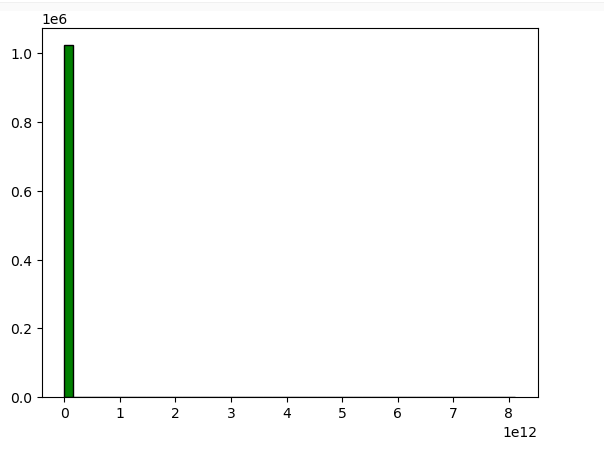
50 bins distribution lol 


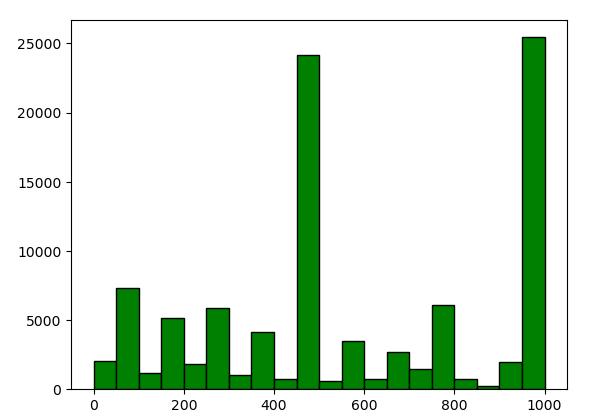
*This shows the distribution of values from 0 to 1000, in 20 bins.*

filtered_data = tn_auto_reg.query('price <=1000')
plt.hist(filtered_data["price"], color='green', ec='black', bins=20)

*Deciding to set the lower limit at a reasonable spot so that the data makes more sense.  A car or truck simply is not sold for *$.05, or even $5 or $50.  

There is a heavy distribution at $500. 
Arbitrarily choosing $100 as the lower limit according to this range, feels safe. 

Revision note - there's a few logical drops to make on this data
*

In [14]:
#restore backup data so don't have to reload from disc again 
#worth the memory!
tn_auto_reg = tn_auto_reg_backup

In [15]:
#Dropping all data that is missing 
tn_auto_reg = tn_auto_reg.dropna()

tn_auto_reg.value_counts("vehicle_type")

vehicle_type
AUTO                    6684187
TRUCK                   1711536
FREIGHT/SEMI TRAILER     377527
MOTORCYCLE               298280
UTILITY (BOX/CARGO)      117752
CAMPER TRAILER            99838
OTHER                     71248
MOBILE HOME/HOUSE TR      53254
UTILITY (FLAT BED) T      44982
RECREATION/MOTOR HOM      20254
BUS - COMMERCIAL           7864
LIVESTOCK/HORSE TRAI       6195
WATERCRAFT TRAILER         3101
SCHOOL BUS                 2122
Multipurpose Vehicle         22
VAN                          19
dtype: int64

In [16]:
# Create a Boolean mask for the desired vehicle types
#vehicle_types = ['AUTO'] 
vehicle_types = ['AUTO', 'TRUCK']
#vehicle_types = ['AUTO', 'TRUCK', 'MOTORCYCLE']
mask = tn_auto_reg['vehicle_type'].isin(vehicle_types)

# Drop the rows that don't match the mask
tn_auto_reg.drop(tn_auto_reg[~mask].index, inplace=True)
tn_auto_reg.value_counts("vehicle_type")

C:\Users\shieldsbobb\AppData\Local\Temp\ipykernel_23576\4123166332.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tn_auto_reg.drop(tn_auto_reg[~mask].index, inplace=True)


vehicle_type
AUTO                    6684187
TRUCK                   1711536
BUS - COMMERCIAL              0
CAMPER TRAILER                0
FREIGHT/SEMI TRAILER          0
LIVESTOCK/HORSE TRAI          0
MOBILE HOME/HOUSE TR          0
MOTORCYCLE                    0
Multipurpose Vehicle          0
OTHER                         0
RECREATION/MOTOR HOM          0
SCHOOL BUS                    0
UTILITY (BOX/CARGO)           0
UTILITY (FLAT BED) T          0
VAN                           0
WATERCRAFT TRAILER            0
dtype: int64

In [17]:
#Drop commerical trucks, motorcyle, and RV brands that snuck through the above filter. 
tn_auto_reg = tn_auto_reg.drop(tn_auto_reg[tn_auto_reg['make'] == "INTL"].index)
tn_auto_reg = tn_auto_reg.drop(tn_auto_reg[tn_auto_reg['make'] == "HD"].index)
tn_auto_reg = tn_auto_reg.drop(tn_auto_reg[tn_auto_reg['make'] == "SUZI"].index)
tn_auto_reg = tn_auto_reg.drop(tn_auto_reg[tn_auto_reg['make'] == "KAWK"].index)
tn_auto_reg = tn_auto_reg.drop(tn_auto_reg[tn_auto_reg['make'] == "KW"].index)
tn_auto_reg = tn_auto_reg.drop(tn_auto_reg[tn_auto_reg['make'] == "PTRB"].index)
tn_auto_reg = tn_auto_reg.drop(tn_auto_reg[tn_auto_reg['make'] == "CANA"].index)
tn_auto_reg = tn_auto_reg.drop(tn_auto_reg[tn_auto_reg['make'] == "HINO"].index)
tn_auto_reg = tn_auto_reg.drop(tn_auto_reg[tn_auto_reg['make'] == "GENS"].index)
tn_auto_reg = tn_auto_reg.drop(tn_auto_reg[tn_auto_reg['make'] == "MACK"].index)
tn_auto_reg = tn_auto_reg.drop(tn_auto_reg[tn_auto_reg['make'] == "POLS"].index)
tn_auto_reg = tn_auto_reg.drop(tn_auto_reg[tn_auto_reg['make'] == "MASE"].index)
tn_auto_reg = tn_auto_reg.drop(tn_auto_reg[tn_auto_reg['make'] == "GENS"].index)
tn_auto_reg = tn_auto_reg.drop(tn_auto_reg[tn_auto_reg['make'] == "WINN"].index)
tn_auto_reg = tn_auto_reg.drop(tn_auto_reg[tn_auto_reg['make'] == "FRHT"].index)

tn_auto_reg['make'].value_counts().tail(30)

DUTT    1
AMRS    1
BOND    1
GRIS    1
SAMP    1
JTCI    1
ALLR    1
MTZR    1
CMDR    1
CASH    1
PAYN    1
TRO     1
STCC    1
FVRO    1
WARM    1
LRCT    1
EVLF    1
L&S     1
COXS    1
TPD     1
KINE    1
PRNE    1
BROV    1
TRNH    1
QUTY    1
DUAL    1
TRAH    1
CRTT    1
WOTR    1
ALOH    1
Name: make, dtype: int64

Real world adjustments!  Setting limits and dropping data 


In [18]:
print("Mileage stats before trim") 
print(tn_auto_reg["mileage"].describe().round())

Mileage stats before trim
count    8.221184e+06
mean    -2.600000e+01
std      4.867419e+06
min     -2.256996e+08
25%      0.000000e+00
50%      1.500000e+01
75%      4.944400e+04
max      2.147484e+09
Name: mileage, dtype: float64


In [19]:
#dropping 0 < mileage 750,000 as absurd errors
tn_auto_reg = tn_auto_reg.loc[tn_auto_reg["mileage"] > 0]
tn_auto_reg = tn_auto_reg.loc[tn_auto_reg["mileage"] <= 750000]

print("0 < mileage < 750k") 
tn_auto_reg["mileage"].describe().round()


0 < mileage < 750k


count    4913566.0
mean        -250.0
std        59130.0
min            1.0
25%           51.0
50%        35892.0
75%        88329.0
max       750000.0
Name: mileage, dtype: float64

In [20]:
print("Price stats before trim") 
tn_auto_reg["price"].describe().round()

Price stats before trim


count    4.913566e+06
mean     2.438680e+06
std      3.733799e+09
min     -4.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.020000e+02
max      8.118003e+12
Name: price, dtype: float64

In [21]:
#dropping 0 < price < 10mil as absurd errors
tn_auto_reg = tn_auto_reg.loc[tn_auto_reg["price"] > 0]
tn_auto_reg = tn_auto_reg.loc[tn_auto_reg["price"] < 10000000]

print("0 < price < $10mil") 
tn_auto_reg["price"].describe().round()

0 < price < $10mil


count    1276910.0
mean       22995.0
std        42230.0
min            0.0
25%         7000.0
50%        18400.0
75%        32476.0
max      9534253.0
Name: price, dtype: float64

In [22]:
#'age' as a computed column
tn_auto_reg['age'] = tn_auto_reg['purchase_date'].dt.year - tn_auto_reg['model_year']
print("Age stats before trim: ")
tn_auto_reg['age'].describe().round()

Age stats before trim: 


count    1276910.0
mean           5.0
std            5.0
min         -220.0
25%            1.0
50%            4.0
75%            8.0
max          989.0
Name: age, dtype: float64

In [23]:
#dropping -2 < age < 200 as absurd errors
tn_auto_reg = tn_auto_reg.loc[tn_auto_reg["age"] > -2] #allowing for 1.9999 because ..
    #cars are made in one year, for the next model year. introduces fluff but manufacture date not available 
tn_auto_reg = tn_auto_reg.loc[tn_auto_reg["age"] < 200]
print("Updated: -2 < Age < 100 stats: ")
tn_auto_reg["age"].describe().round()

Updated: -2 < Age < 100 stats: 


count    1276581.0
mean           5.0
std            5.0
min           -1.0
25%            1.0
50%            4.0
75%            8.0
max          105.0
Name: age, dtype: float64

In [24]:
#looking at spread of brands
tn_auto_reg['make'].value_counts()

#Average price by brand?  Distribution of each brand 
#good to proceed with good, cheap, luxury brands

FORD    214465
CHEV    180983
NISS    143363
TOYT    121299
HOND     72539
         ...  
OREI         1
TRIN         1
BTM          1
HAUL         1
AMST         1
Name: make, Length: 1108, dtype: int64

In [25]:
#dropping brand that have less than 200 transactions in the population 
make_counts = tn_auto_reg["make"].value_counts()
tn_auto_reg = tn_auto_reg.loc[tn_auto_reg["make"].isin(make_counts[make_counts > 200].index)]
#looking at spread of brands
print("total rows after removal of brands with less than 200 transactions = " + str(len(tn_auto_reg) )+"\n" )
print("Rarest 30 makers")
tn_auto_reg['make'].value_counts().tail(30)


total rows after removal of brands with less than 200 transactions = 1269686

Rarest 30 makers


CHRY    17589
BUIC    16407
LEXS    16347
MERZ    16306
CADI    14877
MAZD    13867
INFI    12761
AUDI     9043
LINC     8740
ACUR     7832
MITS     6134
LNDR     5487
VOLV     4581
PORS     3675
MNNI     3336
PONT     2450
ISU      2021
JAGU     1976
SCIO     1962
FIAT     1774
MERC     1637
TESL     1465
STRN     1202
SMRT      573
YAMA      528
HUMM      409
OLDS      375
ALFA      375
FERR      244
BENT      217
Name: make, dtype: int64

In [26]:
print("Top 20 makers in registration count")
tn_auto_reg['make'].value_counts().head(20)

Top 20 makers in registration count


FORD    214465
CHEV    180983
NISS    143363
TOYT    121299
HOND     72539
JEEP     60520
GMC      58971
DODG     51974
RAM      44991
HYUN     43323
KIA      40906
SUBA     25140
VOLK     18942
BMW      18080
CHRY     17589
BUIC     16407
LEXS     16347
MERZ     16306
CADI     14877
MAZD     13867
Name: make, dtype: int64

In [27]:
tn_auto_reg[["price","make","model","model_year"]].loc[ (tn_auto_reg["make"] =="MERC") | 
                                                       (tn_auto_reg["make"] =="MERZ") ].sample(15).round()

,price,make,model,model_year
6016401,35069.0,MERZ,TK,2017
9272053,14000.0,MERZ,WDC,2015
6407926,19000.0,MERZ,SL5,2011
5739145,22050.0,MERZ,E35,2014
9187658,24688.0,MERZ,G25,2015
6319412,8400.0,MERZ,LK3,2004
8684819,31428.0,MERZ,GL3,2014
9264293,33590.0,MERZ,L55,2014
6004431,41042.0,MERZ,TK,2022
4047483,68724.0,MERZ,GLE,2019


In [28]:
#confirmed by sampling models represented that MERC and MERZ both stand for mercedes.  choosing one to keep
tn_auto_reg.loc[tn_auto_reg['make'] == 'MERZ', 'make'] = 'MERC'
print("Replaced all instances of MERZ with MERC.")

Replaced all instances of MERZ with MERC.


In [29]:
tn_auto_reg["make"].value_counts()

FORD    214465
CHEV    180983
NISS    143363
TOYT    121299
HOND     72539
JEEP     60520
GMC      58971
DODG     51974
RAM      44991
HYUN     43323
KIA      40906
SUBA     25140
VOLK     18942
BMW      18080
MERC     17943
CHRY     17589
BUIC     16407
LEXS     16347
CADI     14877
MAZD     13867
INFI     12761
AUDI      9043
LINC      8740
ACUR      7832
MITS      6134
LNDR      5487
VOLV      4581
PORS      3675
MNNI      3336
PONT      2450
ISU       2021
JAGU      1976
SCIO      1962
FIAT      1774
TESL      1465
STRN      1202
SMRT       573
YAMA       528
HUMM       409
OLDS       375
ALFA       375
FERR       244
BENT       217
Name: make, dtype: int64

In [30]:
#adding indexes for brand categories
# popular, imported, luxury, other

# create lists for the popular, luxury, and other brands
popular = ['FORD', 'CHEV', 'NISS', 'TOYT', 'HOND', 'JEEP', 'GMC', 'DODG', 'RAM', 'HYUN', 'KIA', 'SUBA']
imported = ['INFI', 'ACUR', 'MITS', 'LNDR', 'VOLV', 'MNNI', 'SCIO', 'FIAT', 'TRIU', 'MAZD','VOLK','FIAT','ISU']
sports = ['BMW', 'PORS', 'LEXU', 'JAGU', 'ALFA', 'AUDI', 'MERC']
luxury = ['LEXS', 'CADI', 'FERR', 'BENT', 'LAMO', 'LOTU', 'TESL']
discontinued = ['CHRY', 'BUIC', 'PONT', 'OLDS', 'ROL', 'RIVI']
other = ['OTHER']

# create dummy variables
tn_auto_reg['make_cat_popular'] = tn_auto_reg['make'].isin(popular).astype(int)
tn_auto_reg['make_cat_imports'] = tn_auto_reg['make'].isin(imported).astype(int)
tn_auto_reg['make_cat_sports'] = tn_auto_reg['make'].isin(sports).astype(int)
tn_auto_reg['make_cat_luxury'] = tn_auto_reg['make'].isin(luxury).astype(int)
tn_auto_reg['make_cat_discontinued'] = tn_auto_reg['make'].isin(discontinued).astype(int)

# 4/16/23 Update - Fixing this to exclude vehicles that exist in the named groups 
tn_auto_reg['make_cat_other'] = tn_auto_reg['make'].apply(lambda x: int(x not in popular and x not in luxury and x not in imported
                                                                    and x not in sports and x not in discontinued))

print("Luxury Car Stats")
temp = tn_auto_reg.loc[tn_auto_reg["make_cat_luxury"] == 1]
#temp["make_cat_popular"].describe()
temp.describe().round()

Luxury Car Stats


,price,mileage,model_year,age,make_cat_popular,make_cat_imports,make_cat_sports,make_cat_luxury,make_cat_discontinued,make_cat_other
count,33150.0,33150.0,33150.0,33150.0,33150.0,33150.0,33150.0,33150.0,33150.0,33150.0
mean,33921.0,59266.0,2015.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0
std,74462.0,55353.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.0,1.0,1948.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0
25%,13000.0,16108.0,2012.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0
50%,26581.0,45278.0,2015.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0
75%,44648.0,90126.0,2018.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0
max,9534253.0,720010.0,2023.0,74.0,0.0,0.0,0.0,1.0,0.0,0.0


In [31]:
#adding indexes for car vs. truck
# Create dummy columns for new_used
car_truck_dummies = pd.get_dummies(tn_auto_reg['vehicle_type'], prefix='type', dummy_na=False)

# Drop columns with zero rows
car_truck_dummies = car_truck_dummies.loc[:, (car_truck_dummies != 0).any(axis=0)]

# Add the new columns to the original dataframe
tn_auto_reg = pd.concat([tn_auto_reg, car_truck_dummies], axis=1)

print("Car Stats")
tn_auto_reg.loc[tn_auto_reg["type_AUTO"] == 1].describe().round()

Car Stats


,price,mileage,model_year,age,make_cat_popular,make_cat_imports,make_cat_sports,make_cat_luxury,make_cat_discontinued,make_cat_other,type_AUTO,type_TRUCK
count,1008827.0,1008827.0,1008827.0,1008827.0,1008827.0,1008827.0,1008827.0,1008827.0,1008827.0,1008827.0,1008827.0,1008827.0
mean,20689.0,277.0,2015.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
std,39275.0,64577.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,1.0,1915.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25%,6000.0,8890.0,2012.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
50%,16500.0,54061.0,2015.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
75%,29089.0,111425.0,2018.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
max,9534253.0,750000.0,2023.0,105.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [32]:
print("Truck Stats")
tn_auto_reg.loc[tn_auto_reg["type_TRUCK"] == 1].describe().round()

Truck Stats


,price,mileage,model_year,age,make_cat_popular,make_cat_imports,make_cat_sports,make_cat_luxury,make_cat_discontinued,make_cat_other,type_AUTO,type_TRUCK
count,260859.0,260859.0,260859.0,260859.0,260859.0,260859.0,260859.0,260859.0,260859.0,260859.0,260859.0,260859.0
mean,30975.0,6521.0,2015.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
std,47249.0,75312.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,1.0,1929.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
25%,13500.0,285.0,2012.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
50%,28451.0,52561.0,2016.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
75%,44015.0,120258.0,2019.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
max,7575000.0,749179.0,2023.0,92.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0


In [33]:
#adding indexes for used versus new 
# Create dummy columns for new_used
new_used_dummies = pd.get_dummies(tn_auto_reg['new_used'], prefix='new_used')

# Add the new columns to the original dataframe
tn_auto_reg = pd.concat([tn_auto_reg, new_used_dummies], axis=1)

print("New Car Stats")
tn_auto_reg.loc[tn_auto_reg["new_used_N"] == 1].describe().round()

New Car Stats


,price,mileage,model_year,age,make_cat_popular,make_cat_imports,make_cat_sports,make_cat_luxury,make_cat_discontinued,make_cat_other,type_AUTO,type_TRUCK,new_used_N,new_used_U
count,243187.0,243187.0,243187.0,243187.0,243187.0,243187.0,243187.0,243187.0,243187.0,243187.0,243187.0,243187.0,243187.0,243187.0
mean,43744.0,664.0,2020.0,-0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
std,64894.0,9330.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,1.0,1930.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25%,29191.0,10.0,2019.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
50%,38970.0,16.0,2020.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
75%,51478.0,52.0,2021.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
max,9534253.0,749179.0,2023.0,91.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [34]:
print("Used Car Stats")
tn_auto_reg.loc[tn_auto_reg["new_used_U"] == 1].describe().round()

Used Car Stats


,price,mileage,model_year,age,make_cat_popular,make_cat_imports,make_cat_sports,make_cat_luxury,make_cat_discontinued,make_cat_other,type_AUTO,type_TRUCK,new_used_N,new_used_U
count,1026499.0,1026499.0,1026499.0,1026499.0,1026499.0,1026499.0,1026499.0,1026499.0,1026499.0,1026499.0,1026499.0,1026499.0,1026499.0,1026499.0
mean,17843.0,1772.0,2014.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
std,31294.0,64385.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,1.0,1915.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
25%,5000.0,34004.0,2012.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
50%,14089.0,75750.0,2014.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
75%,25304.0,126214.0,2017.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
max,9349748.0,750000.0,2023.0,105.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0


In [35]:
print("Secondary logical trim, total rows starting point: " + str(len(tn_auto_reg)) )

temp = tn_auto_reg[(tn_auto_reg['age'] > 10) & (tn_auto_reg['mileage'] < 1000)]
print("Deleting vehicles with age over 10 years and mileage less than 1000 miles: " + str(len(temp)) )
tn_auto_reg.drop(temp.index, inplace=True)

temp = tn_auto_reg[(tn_auto_reg['new_used_N']) & (tn_auto_reg['age'] < 1) & (tn_auto_reg['mileage'] > 10000)]
print("Deleting vehicles less than 1 year and mileage over 10,000 miles: " + str(len(temp)) )
tn_auto_reg.drop(temp.index, inplace=True)

temp = tn_auto_reg[(tn_auto_reg['price'] < 500) & (tn_auto_reg['mileage'] < 50000)]
print("Deleting vehicles with price less than $500 and mileage less than 50,000 miles: " + str(len(temp)) )
tn_auto_reg.drop(temp.index, inplace=True)

temp = tn_auto_reg[(tn_auto_reg['price'] < 300) ]
print("Deleting vehicles with price less than $300: " + str(len(temp)) )
tn_auto_reg.drop(temp.index, inplace=True)

temp = tn_auto_reg[(tn_auto_reg['new_used_N']) & ((tn_auto_reg['mileage'] > 500) | (tn_auto_reg['age'] > 1))]
print("Deleting vehicles that are new and (mileage >500 or age > 1):" + str(len(temp)) )
tn_auto_reg.drop(temp.index, inplace=True)

#temp = tn_auto_reg[(tn_auto_reg['age'] > 10) & (tn_auto_reg['price'] > 50000)]
#print("Deleting vehicles with age over 10 years and price over $50,000: " + str(len(temp)) )
#tn_auto_reg.drop(temp.index, inplace=True)

temp = tn_auto_reg.loc[(tn_auto_reg['price'] > 250000) & (~tn_auto_reg['make_cat_luxury'])]
print("Deleting non-luxury vehicles with price over $250,000: " + str(len(temp)) )
tn_auto_reg.drop(temp.index, inplace=True)

#Only 6 deletions - keeping these because they may just be real 
#temp = tn_auto_reg.loc[(tn_auto_reg['price'] > 1000000) & (tn_auto_reg['make_cat_luxury'])]
#print("Deleting luxury vehicles with price over $1mil: " + str(len(temp)) )
#tn_auto_reg.drop(temp.index, inplace=True)

print("Secondary logical trim completed, total rows ending point: " + str(len(tn_auto_reg)) )
tn_auto_reg.describe().round()

Secondary logical trim, total rows starting point: 1269686
Deleting vehicles with age over 10 years and mileage less than 1000 miles: 6314
Deleting vehicles less than 1 year and mileage over 10,000 miles: 427
Deleting vehicles with price less than $500 and mileage less than 50,000 miles: 2851
Deleting vehicles with price less than $300: 13096
Deleting vehicles that are new and (mileage >500 or age > 1):15472
Deleting non-luxury vehicles with price over $250,000: 415
Secondary logical trim completed, total rows ending point: 1231111


,price,mileage,model_year,age,make_cat_popular,make_cat_imports,make_cat_sports,make_cat_luxury,make_cat_discontinued,make_cat_other,type_AUTO,type_TRUCK,new_used_N,new_used_U
count,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0
mean,22538.0,-193.0,2015.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
std,22186.0,66420.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,300.0,1.0,1915.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,7500.0,8525.0,2012.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
50%,18500.0,54849.0,2016.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
75%,32328.0,113099.0,2019.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
max,9534253.0,750000.0,2023.0,105.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [36]:
#Calculate the IQR upper and lower bounds for price
upper_bound, lower_bound = calculate_IQR_bounds(tn_auto_reg, "price")
upper_bound, lower_bound = calculate_IQR_bounds(tn_auto_reg, "age")
upper_bound, lower_bound = calculate_IQR_bounds(tn_auto_reg, "mileage")

q1= 7500.0, q3= 32328.0, iqr= 24828.0
IQR Bounds: -29742.0 <= price <= 69570.0
-----------
q1= 1.0, q3= 8.0, iqr= 7.0
IQR Bounds: -10.0 <= age <= 18.0
-----------
q1= 8525, q3= 113099, iqr= 104574
IQR Bounds: -148336.0 <= mileage <= 269960.0
-----------


In [37]:
#stats printout on price 
# apply decimal formatting to all columns
formatted_desc = tn_auto_reg["price"].describe().apply(lambda x: "{:,.2f}".format(x))

# add currency symbol to specific columns
formatted_desc[["min", "25%", "50%", "75%", "max"]] = formatted_desc[["min", "25%", "50%", "75%", "max"]].apply(lambda x: "${}".format(x))

# print the formatted description
print("Price Statistics, pre IQR cleanup \n")
print(formatted_desc)
#target variable is price, looking at simple stats.  

Price Statistics, pre IQR cleanup 

count     1,231,111.00
mean         22,538.22
std          22,185.65
min            $300.00
25%          $7,500.00
50%         $18,500.00
75%         $32,328.00
max      $9,534,253.00
Name: price, dtype: object


In [38]:
#Drop outliers according to the IQR
#tn_auto_reg = tn_auto_reg.loc[tn_auto_reg["price"] <= upper_bound]
#tn_auto_reg = tn_auto_reg.loc[tn_auto_reg["price"] >= lower_bound]

#tn_auto_reg.describe().round()
print("Canceling IQR drops but might be useful as a later reference")

Canceling IQR drops but might be useful as a later reference


In [39]:
#stats printout on price 
# apply decimal formatting to all columns
formatted_desc = tn_auto_reg["price"].describe().apply(lambda x: "{:,.2f}".format(x))

# add currency symbol to specific columns
formatted_desc[["min", "25%", "50%", "75%", "max"]] = formatted_desc[["min", "25%", "50%", "75%", "max"]].apply(lambda x: "${}".format(x))

# print the formatted description
print("Price Statistics, post cleanup \n")
print(formatted_desc)
#target variable is price, looking at simple stats.  

Price Statistics, post cleanup 

count     1,231,111.00
mean         22,538.22
std          22,185.65
min            $300.00
25%          $7,500.00
50%         $18,500.00
75%         $32,328.00
max      $9,534,253.00
Name: price, dtype: object


In [40]:
#sort the primary dataset by price
tn_auto_reg = tn_auto_reg.sort_values(by='price')

print ("Sorted by price")
tn_auto_reg.tail(20)


Sorted by price


,vin,price,odometer_type,mileage,county,zip,model_year,make,model,vehicle_type,...,make_cat_popular,make_cat_imports,make_cat_sports,make_cat_luxury,make_cat_discontinued,make_cat_other,type_AUTO,type_TRUCK,new_used_N,new_used_U
9261816,ZFF97CMA1N0280723,5.511800e+05,0,41,Davidson,37215,2022,FERR,812,AUTO,...,0,0,0,1,0,0,1,0,1,0
9260951,ZFF97CMA1N0275263,5.583151e+05,0,53,Williamson,37069,2022,FERR,812,AUTO,...,0,0,0,1,0,0,1,0,1,0
8792642,ZFF97CMAXN0271972,5.697270e+05,0,45,Davidson,37203,2022,FERR,812,AUTO,...,0,0,0,1,0,0,1,0,1,0
9289220,ZFF90HLA2K0248023,5.750000e+05,0,128,Maury,38401,2019,FERR,488,AUTO,...,0,0,0,1,0,0,1,0,0,1
6383078,ZFF90HLA9L0255763,6.025590e+05,0,39,Williamson,37069,2020,FERR,488,AUTO,...,0,0,0,1,0,0,1,0,1,0
5822363,ZFF91HMA6L0251293,6.025910e+05,0,38,Williamson,37069,2020,FERR,SPI,AUTO,...,0,0,0,1,0,0,1,0,1,0
9302591,ZFF90HLA8L0248965,6.207950e+05,0,2176,Knox,37922,2020,FERR,488,AUTO,...,0,0,0,1,0,0,1,0,0,1
6441913,ZFF95NLA0N0278867,6.262330e+05,0,45,Williamson,37027,2022,FERR,SF9,AUTO,...,0,0,0,1,0,0,1,0,1,0
9451907,ZFF95NLA0N0274964,6.427580e+05,0,48,State,38103,2022,FERR,SF9,AUTO,...,0,0,0,1,0,0,1,0,1,0
8900851,ZFF78VHAXF0209709,6.500000e+05,0,3320,Maury,38401,2015,FERR,458,AUTO,...,0,0,0,1,0,0,1,0,0,1


Text(0.5, 1.0, 'Histogram of Transactions (Range: 0 to $150k)')

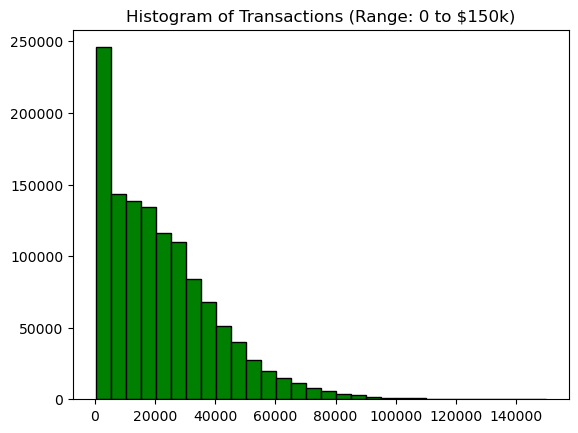

In [41]:
#plot the distribution of the price values
hist_data = tn_auto_reg["price"].loc[tn_auto_reg["price"] <150000]
plt.hist(hist_data, color='green', ec='black', bins=30) #, range=[0,60])
plt.title("Histogram of Transactions (Range: 0 to $150k)")

<AxesSubplot: title={'center': 'All cars'}>

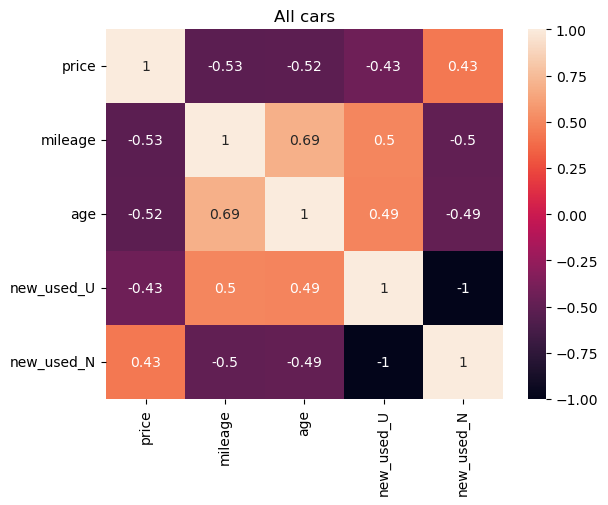

In [42]:
#overall corr analysis
tn_auto_reg_hm = tn_auto_reg[["price","mileage","age",'new_used_U','new_used_N',
                              ]].corr()
#tn_auto_reg_hm
plt.title("All cars")
sns.heatmap(tn_auto_reg_hm, annot=True)


In [43]:
# dates
# as per the loading notebook on the project
tn_auto_reg.describe(include = ['datetime'], datetime_is_numeric=True)

,title_issue_date,purchase_date
count,1231111,1231111
mean,2020-08-03 02:19:39.904005888,2020-06-29 16:00:32.446790400
min,2009-01-23 00:00:00,1984-05-19 00:00:00
25%,2019-05-07 00:00:00,2019-04-06 00:00:00
50%,2020-08-28 00:00:00,2020-07-24 00:00:00
75%,2021-11-03 00:00:00,2021-09-29 00:00:00
max,2022-12-29 00:00:00,2022-12-29 00:00:00


In [44]:
# describe the objects and categories in the dataset
# as per the loading notebook on the project
tn_auto_reg.describe(include = ['object','category']) 

,vin,odometer_type,county,zip,make,model,vehicle_type,new_used
count,1231111,1231111,1231111,1231111,1231111,1231111,1231111,1231111
unique,1125879,4,96,1652,43,5233,2,2
top,1J4NF1GB6BD101941,0,Davidson,38305,FORD,F15,AUTO,U
freq,7,1195912,126626,22656,205977,47718,977892,1004111


In [45]:
print("Especially interesting! Can look for trends by seeing same VIN go down in price as time and mileage goes on")
tn_auto_reg['vin'].describe()

Especially interesting! Can look for trends by seeing same VIN go down in price as time and mileage goes on


count               1231111
unique              1125879
top       1J4NF1GB6BD101941
freq                      7
Name: vin, dtype: object

In [46]:
tn_auto_reg.describe().round()

,price,mileage,model_year,age,make_cat_popular,make_cat_imports,make_cat_sports,make_cat_luxury,make_cat_discontinued,make_cat_other,type_AUTO,type_TRUCK,new_used_N,new_used_U
count,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0
mean,22550.0,-193.0,2015.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
std,22196.0,66420.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,300.0,1.0,1915.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,7500.0,8525.0,2012.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
50%,18500.0,54849.0,2016.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
75%,32328.0,113099.0,2019.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
max,9534253.0,750000.0,2023.0,105.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [47]:
tn_auto_reg.to_csv('tn_auto_reg_filtered_CT3.csv', index=False) #debating whether to preserve the original doc's indicies
#iterated to v3 4/28 but captured 4/30 due to commit push errors (reminder not to include the data file in the future!)

More to follow in the analysis book!